# Movie reviews

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Movie reviews. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [70]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False,ngram_range=(1,3))#smaller the n_features is, the better performance for the training set, but worse for the test set
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")
    movie_data['punc1_count'] = movie_data['review'].str.count("\!") #doesn't help a lot


    X_quant_features = movie_data[["word_count", "punc_count","punc1_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [71]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./moviereviews_train.tsv', my_random_seed=70)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc1_count
0         433          20            1
1         158          16            0
2         378          20            0


# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [72]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 5484, 'TN': 4544, 'FP': 5452, 'FN': 4520, 'Accuracy': 0.5014, 'Precision': 0.5014630577907827, 'Recall': 0.5481807277089165, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [73]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


### MODEL: logistic regression

In [74]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [75]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 9884, 'TN': 9872, 'FP': 124, 'FN': 120, 'Accuracy': 0.9878, 'Precision': 0.9876099120703438, 'Recall': 0.9880047980807677, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [76]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [77]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 10004, 'TN': 9996, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [78]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10004, 'Neg': 9996, 'TP': 7901, 'TN': 7363, 'FP': 2633, 'FN': 2103, 'Accuracy': 0.7632, 'Precision': 0.7500474653502943, 'Recall': 0.7897840863654538, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

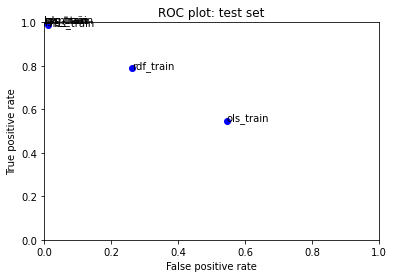

In [79]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [80]:
ols_predictions = ols.predict(X_train)

### let's look at some false positives:

In [81]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')


Examples of false positives:
60
Yay!... I think. It's hard to say. It's hard to have an emotion about a movie that has no emotion. This movie is as sterile as a surgeon's scalpel. For a setting, it has a few stone pillars, some stone seats, a couple stone crosses and some stone actors. They have no emotion! The only thing that saves this movie is the fact that it is Hamlet, and Hamlet is a terrificly written piece of literature. The dubbing really wasn't all that bad though. The voices stuck true to the dull, gloomy, dreary, life-sucking atmosphere the movie gave forth. I have seen this version of Hamlet on the fabulous Mystery Science Theater 3000 three times, and each of the three times, I was on the brink of turning off the TV, despite it being MST 3K.<br /><br />Not an uplifting production of a drama that deserves so much better.
* * * * * * * * * 
183
This show is possibly the biggest, ugliest, most generic steam pile I've seen in children's programming that's actually become succ

3508
This was the worst movie I saw at WorldFest and it also received the least amount of applause afterwards! I can only think it is receiving such recognition based on the amount of known actors in the film. It's great to see J.Beals but she's only in the movie for a few minutes. M.Parker is a much better actress than the part allowed for. The rest of the acting is hard to judge because the movie is so ridiculous and predictable. The main character is totally unsympathetic and therefore a bore to watch. There is no real emotional depth to the story. A movie revolving about an actor who can't get work doesn't feel very original to me. Nor does the development of the cop. It feels like one of many straight-to-video movies I saw back in the 90s ... And not even a good one in those standards.<br /><br />
* * * * * * * * * 
3541
Here's how you do it: Believe in God and repent for your sins. Then things should turn around within the next day or so. <br /><br />Until the last fifteen minute

6368
Normally when I write a review for a movie online, it is for one of three reasons. Either, I have found something exceptionally lacking in a film that otherwise would have been excellent, I feel that the public's perception of a film before viewing it is inaccurate for a number of reasons, or I believe that the purpose or message of a film needs to be clarified or explained with the help of other reviewers. While all of these reasons may appear to be somewhat negative, I find that writing a review that lavishes nothing but praise and statements such as, \This is one of the best films of all time!\", does nothing to enlighten a potential viewer on its merits and downsides, nor does it often give reasoning as to why a movie is so good, which should be the point of the review in the first place. With that being said, War of the Worlds is nothing more than a hurried, incompetent attempt at a money grab; piggy-backing its loathsome carcass on the multi-million dollar advertising campai

9126
This film comes as the ultimate disappointment in Tsai Ming-Liang for me. It oozes laziness from its every frame. So I'm not going to analyse it thoroughly either. But some observations:<br /><br />1. If the premise is drought, why we get to see city landscapes with blooming green trees? I wonder if that was supposed to mean something in the metaphorical context of the film (in which thirst notifies the craving for intimacy, and watermelon the trivial substitute, sex). Or it is only a matter of lousy film-making, not giving a damn about being coherent.<br /><br />2. We don't get to know what had happened to the porn actress, why she is unconscious or, presumably, dead. It seems a question of no importance as long as the message of supreme alienation is successfully (=bombastically) delivered, but in retrospect, her inert body proves to be a cheap dramaturgical gimmick, a pretext  just as gratuitous and exploitative as the activity it is employed in.<br /><br />3. Nothing is expre

12021
I normally have no problem walking away from a bad movie, however this was an unique case. This movie was so bad that I actually sat through the whole thing almost praying it would have one minute of good movie time to justify the hour and a half that was wasted. Needless to say I was brutally disappointed. Set at a beach house where a group of college friends are celebrating vacation, this movie suffers from numerous problems making it not worth seeing. First, there are gaping plot holes. Second, very few of the C-list (i don't even dare call them B) actors can act worth a damn, so any scenes that have potential fail miserably. Third, the rate of the film is very choppy and awkward to watch most of the time making suspense building very difficult, leading to very few surprises for the audience. Fourth and most importantly, the ending is completely anti-climatic partially because of how it ends (setting/who the killer turns out to be) and partially because the dialog is just atro

15186
Dahmer, a young confused man. Dahmer, a confusing movie. Granted, I had a few beers while watching the movie, but that doesn't explain why I got so bored by this flick.<br /><br />Its flashbacks are nothing but confusing and annoying, and there's no real storyline with a beginning and an end, the only thing that made sense in the movie was the explaining text in the beginning and at the very end of the movie. The inbetween stuff, which would be the movie, is just boring images and a waste of time. <br /><br />We never see actual murders, everything is just a bunch of insinuations. Sometimes you even just get a feeling that Dahmer's dreaming the entire thing, but you know he isn't, since it's<br /><br />based on a true story and this actually happened, at least most of it. But what happened? It's not easy to tell.<br /><br />I do not encourage people to waste time on this movie. I<br /><br />didn't like it one bit and I felt cheated when it suddenly ended. <br /><br />*/*****
* * 

18024
Near the closing stages of Baby Mama, one of the central characters goes on to describe the basic outline of everything that came before and summarises that it 'was all just a mess'; I really couldn't say it any better than that. And while the feature does have its odd ray of hope every now and again, the vast majority of what is present is too neutered to be considered relevant and too unremarkable to be worth anyone's time. A lacklustre cast, mundane script and vague, caricature characters ensure that Baby Mama certainly isn't taxing on the ol' noggin, but it never makes up for this through its proposed sense of humour. Consisting mainly of very routine, cliché jokes based around an odd couple (rich and poor) trying to live with each other as they prepare to bring a baby into the world, the film is far too esoteric to deliver laughs outside its very thin demographic.<br /><br />As a story on finding love, it's not that bad, but playing this plot line as a side-story of sorts to

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [82]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1404, 'TN': 1032, 'FP': 1472, 'FN': 1092, 'Accuracy': 0.4872, 'Precision': 0.48817802503477054, 'Recall': 0.5625, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [83]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2043, 'TN': 2037, 'FP': 467, 'FN': 453, 'Accuracy': 0.816, 'Precision': 0.8139442231075698, 'Recall': 0.8185096153846154, 'desc': 'svm_test'}


### MODEL: logistic regression

In [84]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2058, 'TN': 2043, 'FP': 461, 'FN': 438, 'Accuracy': 0.8202, 'Precision': 0.8169908693926161, 'Recall': 0.8245192307692307, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [85]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2159, 'TN': 2084, 'FP': 420, 'FN': 337, 'Accuracy': 0.8486, 'Precision': 0.83714618069019, 'Recall': 0.8649839743589743, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [86]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2063, 'TN': 2050, 'FP': 454, 'FN': 433, 'Accuracy': 0.8226, 'Precision': 0.8196265395311879, 'Recall': 0.8265224358974359, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [87]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 2182, 'TN': 2123, 'FP': 381, 'FN': 314, 'Accuracy': 0.861, 'Precision': 0.85134607881389, 'Recall': 0.874198717948718, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [88]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2496, 'Neg': 2504, 'TP': 1923, 'TN': 1834, 'FP': 670, 'FN': 573, 'Accuracy': 0.7514, 'Precision': 0.7416120323949094, 'Recall': 0.7704326923076923, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

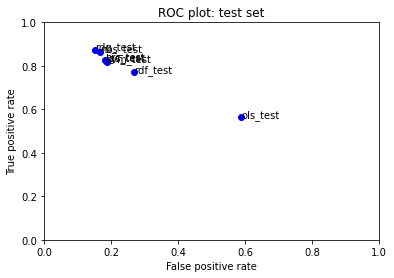

In [90]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [91]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='./moviereviews_test.tsv', my_random_seed=70, test=True)
print("Number of rows in the submission test set (should be 25,000): ")

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 2 columns 

the data types for each of the columns in movie_data:
id        object
review    object
dtype: object 

the first 10 rows in movie_data:
         id                                             review
0  12311_10  Naturally in a film who's main themes are of m...
1    8348_2  This movie is a disaster within a disaster fil...
2    5828_4  All in all, this is a movie for kids. We saw i...
3    7186_2  Afraid of the Dark left me with the impression...
4   12128_7  A very accurate depiction of small time mob li...
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  punc1_count
0         131           5            0
1         169          15            1
2         176          18            0
3         112           5            0
4         133           8            0
5         331          20            1
6         121    

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [92]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.50084


In [93]:
raw_data.head()

,id,review,word_count,punc_count,punc1_count
0,12311_10,Naturally in a film who's main themes are of m...,131,5,0
1,8348_2,This movie is a disaster within a disaster fil...,169,15,1
2,5828_4,"All in all, this is a movie for kids. We saw i...",176,18,0
3,7186_2,Afraid of the Dark left me with the impression...,112,5,0
4,12128_7,A very accurate depiction of small time mob li...,133,8,0


In [94]:
my_submission.head()

,id,prediction
0,12311_10,1
1,8348_2,0
2,5828_4,0
3,7186_2,0
4,12128_7,1


In [95]:
my_submission.shape

(25000, 2)

In [97]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('./moviereviews_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation